# Guided Project: Kaggle Titanic Competition

## Introduction

In this project, we tackle the Titanic competition, one of the most popular competitions from the Kaggle platform.

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we will build a predictive model that answers the question: “What sorts of people were more likely to survive?” using passenger data (ie. name, age, gender, socio-economic class, etc).

## Librairies and Modules Import

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import minmax_scale
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## The Data

For this competition, we are given access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

The `train.csv` dataset contains the details of a subset of the passengers on board (891 to be exact) and importantly, reveals whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s our job to predict these outcomes.

Using the patterns we find in the `train.csv` data, we will predict whether the other 418 passengers on board (found in `test.csv`) survived.

Let's import these two datasets!

In [49]:
train = pd.read_csv("train.csv")
train_shape = train.shape

holdout = pd.read_csv("test.csv")
holdout_shape = holdout.shape

print(train_shape)
print(holdout_shape)

(891, 12)
(418, 11)


The Kaggle Titanic challenge page also features a data dictionnary which explains the various columns that make up the datasets. Below are the descriptions contained in that data dictionary:

* `PassengerID` - A column added by Kaggle to identify each row and make submissions easier
* `Survived` - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
* `Pclass` - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
* `Sex` - The passenger's sex
* `Age` - The passenger's age in years
* `SibSp` - The number of siblings or spouses the passenger had aboard the Titanic
* `Parch` - The number of parents or children the passenger had aboard the Titanic
* `Ticket` - The passenger's ticket number
* `Fare` - The fare the passenger paid
* `Cabin` - The passenger's cabin number
* `Embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

We print the first few rows of the train dataset to get familiar with it.

In [50]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In the next section, we explore the datasets further to try and uncover interesting patterns in the data.

## Exploratory Data Analysis

Understanding the Titanic disaster and specifically what variables might affect the outcome of survival is important and will help us select the best predictors. Anyone who has watched the movie Titanic would remember that women and children were given precedence to lifeboats (as they were in real life). One would also remember the vast class disparity of the passengers.

This indicates that the age, sex and class of a passenger (`Age`, `Sex`, and `PClass`) may be good predictors of his/her survival. Other information such as the price of his/her ticket as well as the number of family members he/she has onboard may also be valuable.

In this section, we analyse the different columns from our dataset and evaluate their relevance for survival prediction.

### `Sex`

Because the `Survive` column contains `0` if the passenger did not survive and `1` if they did, we can segment our data by sex and calculate the mean of this column. We can use `DataFrame.pivot_table()` to easily do this:

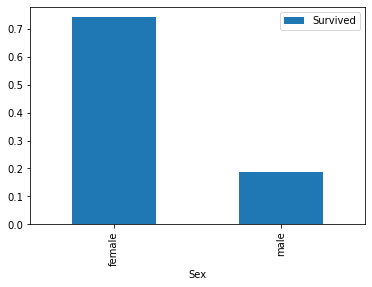

In [51]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

The `Sex` column is a categorical feature. From the bar plot above, we can confirm that the survival rate for females was higher than for men as females were given precedence in life boats. 
This feature seems to be a good predictor.

Let's now look at the `Pclass` column.

### `Pclass`

In the same way as we just did with the `Sex` column, we plot here the survival rate for the different classes.

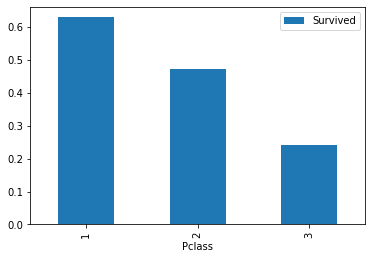

In [52]:
pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

It seems that there is a statistical difference in chances of survival depending on the passenger class. As we would expect, passengers from first class had the highest survival rate. This may be because they are given precedence in life boats or because their cabins were on the higher decks, thus making them the first ones to reach the lifeboats.

In any case, this feature may prove to be a good predictor.

Next, we look in details at the `Age` column.

### `Age`

Let's take a look at the `Age` column using `Series.describe()`.

In [53]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The `Age` column contains numbers ranging from `0.42` to `80.0` (looking at Kaggle's data page, we are informed that `Age` is fractional if the passenger is less than one). The other thing to note here is that there are 714 values in this column, fewer than the 891 total rows the `train` dataset has, which indicates we have some missing values.

`Age` is a continuous numerical column. We can then create two histograms to compare visually those who survived to those who died across different age ranges:

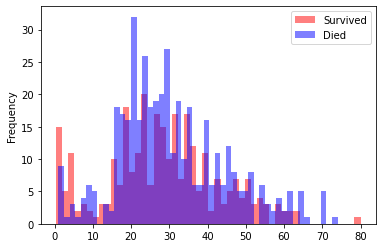

In [54]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived (where the red bars are higher than the blue bars).

In order for this feature to be useful to our machine learning model, we could turn it into a categorical feature by dividing it into ranges. This is done in the later "Feature Engineering" section.

We now move on to the `SibSp` column.

### `SibSp`

As explained earlier, the `SibSp` column informs us on the number of siblings or spouses the passenger had aboard the Titanic.

Let's look at the counts of values in this column!

In [55]:
train["SibSp"].value_counts(dropna=False)

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

We can quickly see that there are 7 unique values and that a vast majority of passengers had no siblings or spouses onboard.

We can plot the survival rate per unique value in this column.

<AxesSubplot:xlabel='SibSp'>

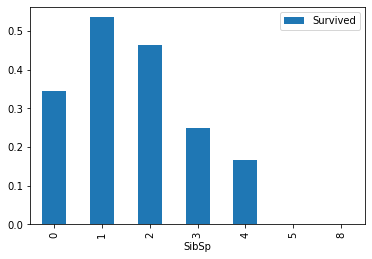

In [56]:
sibsp_pivot = train.pivot_table(index="SibSp", values="Survived")
sibsp_pivot.plot.bar()

There is no clear trend here between the number of siblings or spouses a passenger had onboard and his/her chances of survival. We can still see that the values `1` and `2` have the highest survival rate.
There may have been larger families in the upper class, as wealthy people would have been able to afford tickets for members of their family. And we just saw that people from the upper class had a higher survival rate.

On the opposite, there may have been a high proportion of poor single men or women doing this trip on their own hoping to start a new life in the USA.

Next, we inspect the `Parch` column.

### `Parch`

As explained earlier, the `Parch` column informs us on the number of parents or children the passenger had aboard the Titanic.

Let's look at the counts of values in this column!

In [57]:
train["Parch"].value_counts(dropna=False)

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

The distribution of values seems quite similar to that of the `SibSp` column. We also have here 7 unique values.

Again, we plot the survival rate per unique value in this column.

<AxesSubplot:xlabel='Parch'>

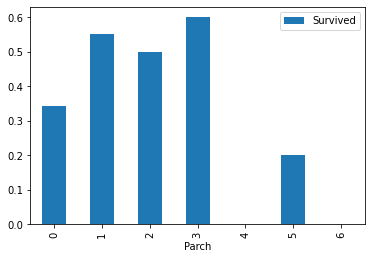

In [58]:
sibsp_pivot = train.pivot_table(index="Parch", values="Survived")
sibsp_pivot.plot.bar()

We can observe that people having 1 to 3 parents or children had a statistically higher survival rate than people who had none.

We can imagine that women with children were given precedence in life boats before men or women who did not have any.
Also, we see that a few passengers who were part of larger families had less survival chances. This may be due to the fact that they did not want to abandon each other and prefered to stay together on the sinking boat.

`SibSp` and `Parch` columns convey the same type of information and it would make sense to combine them in a single feature that we would use to make our predictions. We address that combination in the "Feature Engineering" section.

Let's look next at the `Ticket` column.

### `Ticket`

We start by looking at the number of unique values in that column.

In [59]:
train["Ticket"].value_counts(dropna=False)

347082      7
1601        7
CA. 2343    7
3101295     6
347088      6
           ..
347061      1
343095      1
363592      1
65303       1
4138        1
Name: Ticket, Length: 681, dtype: int64

There are a total of 681 unique values. And by looking at a couple of them, it is unlikely that we will be able to extract any useful information from them.

### `Fare`

Let's now look at the `Fare` column!

In [60]:
train["Fare"].value_counts(dropna=False)

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

There are a total of 248 difference prices.

In [61]:
train["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

The `Fare` column doesn't contain any null values.
At least one row seems to feature a price of $0. It may be that the passenger was invited onboard or that tickets were free for very young children. Let's look at those rows.

In [62]:
train[train["Fare"]==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


All the passengers with a $0 assigned ticket were men. Although the age is missing for most of them, the others are adult.
    
It may be that they forgot to record this information for those particular passengers.

We plot below the frequency distribution of fares for passengers who survived and those who didn't.

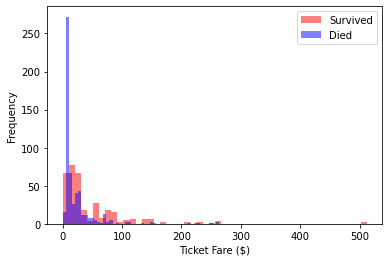

In [63]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

survived["Fare"].plot.hist(alpha=0.5,color='red',bins=50)
died["Fare"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.xlabel("Ticket Fare ($)")
plt.show()

We can get rid of the oultier at $512 to better visualize the histograms. 

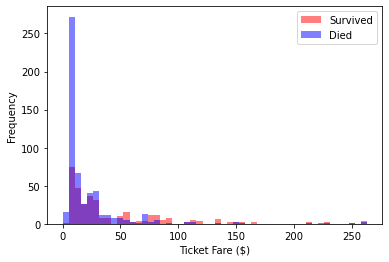

In [64]:
survived[survived["Fare"]<500]["Fare"].plot.hist(alpha=0.5,color='red',bins=50)
died[died["Fare"]<500]["Fare"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.xlabel("Ticket Fare ($)")
plt.show()

We can see that people with cheaper tickets died in a higher proportion than those with more expensive tickets. This column could be a useful feature.

As for the `Age` column, we could turn it into a categorical feature by dividing it into ranges. This is done in the "Feature Engineering" section.

### `Cabin`

We now look at the `Cabin` column.

In [65]:
train["Cabin"].value_counts(dropna=False)

NaN            687
G6               4
C23 C25 C27      4
B96 B98          4
D                3
              ... 
C128             1
C46              1
D28              1
E36              1
C45              1
Name: Cabin, Length: 148, dtype: int64

Most of the rows from our dataset have missing `Cabin` values.

While the cabin number will be reasonably unique to each passenger, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be a useful data for us. We would indeed expect cabins to be named and ranked relative to their price or to their location in the boat. People living in lower decks cabins may have had more trouble reaching the upper decks and the life boats. 

We extract the cabin type information in the "Feature Engineering" section.

Next, we look at the `Embarked` column.

### `Embarked`

The `Embark` columns informs us on which city the passenger embarked from (C=Cherbourg, Q=Queenstown, S=Southampton).

In [66]:
train["Embarked"].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

We have two missing values for that column that will be taken care of in the next section.

We can also see that a vast majority of the passengers embarked from Southampton.

Let's plot the survival rate for each of these embarkation cities.

<AxesSubplot:xlabel='Embarked'>

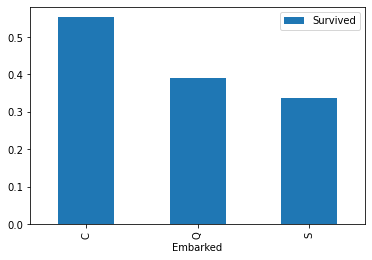

In [67]:
embarked_pivot = train.pivot_table(index="Embarked", values="Survived")
embarked_pivot.plot.bar()

A bit more than 30% of the passengers who embarked in Southampton survived. As a comparison, about 55% of those who embarked in Cherbourg did survive. This needs to be put into perspective with the number of passengers per port. 3.8 times more people embarked at Southampton than at cherbourg, so it is expected to have a lower survival rate for Southampton passengers, life boats being limited in number.

Finally, let's look have a look at the `Name` column.

### `Name`

We expect the `Name` column to have as many unique values as rows. Let's have a look at it!

In [68]:
train[["Name"]]

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
886,"Montvila, Rev. Juozas"
887,"Graham, Miss. Margaret Edith"
888,"Johnston, Miss. Catherine Helen ""Carrie"""
889,"Behr, Mr. Karl Howell"


There seems to be titles like 'Mr' or 'Mrs' within each name, as well as some less common titles, like 'Countess', 'Dr', 'Rev', ... that could be useful information for our predictions.

In the following section, we will extract the titles from the `Name` column and categorize them under fewer, broader ones.

We are now more familiar with the dataset and have spotted some potentially valuable predictors. We have also listed a certain number of actions required to make these features usable by a machine learning model. We address all these actions in the next section.

## Feature Engineering

The previous section helped us uncover patterns in the data and identify some potentially valuable predictors.
In this section, we prepare these features so that they can be used by a machine learning model.

### Converting `Age` to Categorical

We start by dividing the `Age` column values into ranges to make it a categorical feature. To do so, we create a function named `process_age` that:
* uses the `pandas.fillna()` method to fill all of the missing values with `-0.5`
* cuts the `Age` column into the specified segments

In [69]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

We define the following age ranges and associated labels.

In [70]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

We then use that function on both the train and holdout dataframes.

In [71]:
train = process_age(train, cut_points, label_names)
holdout = process_age(holdout, cut_points, label_names)

Finally, we can calculate the survival rate per age category and plot it in a bar graph.

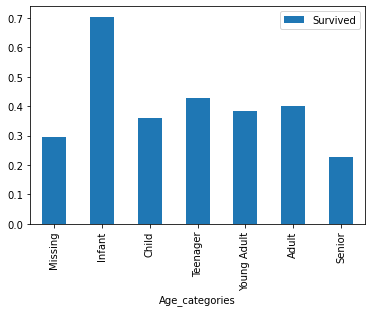

In [72]:
age_pivot = train.pivot_table(index="Age_categories",values="Survived")
age_pivot.plot.bar()
plt.show()

### Converting `Fare` to Categorical

Just as we did with the `Age` column, we divide the `Fare` column in several segments to make it a categorical feature. Also, we fill in the missing values with the column values mean.

In [73]:
def process_fare(df,cut_points,label_names):
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

We define the following price ranges and associated labels.

In [74]:
cut_points = [-1,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

We then use that function on both the train and holdout dataframes.

In [75]:
train = process_fare(train, cut_points, label_names)
holdout = process_fare(holdout, cut_points, label_names)

Finally, we can calculate the survival rate per ticket fare category and plot it in a bar graph.

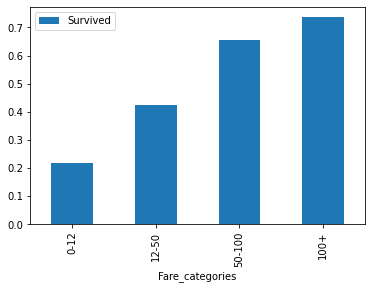

In [76]:
fare_pivot = train.pivot_table(index="Fare_categories",values="Survived")
fare_pivot.plot.bar()
plt.show()

The correlation between the ticket fare and the survival chance appears more clearly after segmentation.

### Extracting the First Letter in `Cabin`

As seen in the EDA section, it may prove useful to extract the first letter of the `Cabin` values and return them in a new `Cabin_type` column that we'll use as predictor.

For that, we create the `process_cabin` function. We will fill any missing values with the label `Unknown`.

In [77]:
def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

Then, we apply this function to the train and holdout sets.

In [78]:
train = process_cabin(train)
holdout = process_cabin(holdout)

train["Cabin_type"].value_counts(dropna=False)

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin_type, dtype: int64

### Filling Null Values in `Embarked`

In the data exploratorion section, we noticed two missing values in the `Embarked` column. We decide to fill them with the most occuring value, `S` for Southampton port.

In [79]:
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train["Embarked"].value_counts(dropna=False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

### Extracting and Categorizing Titles from `Name`

We previously saw that the `Name` column features titles with passengers name, like 'Mr' or 'Mrs', 'Dr', 'Rev', .... By spending some time researching the different titles, we can categorize them into six broader types:
* Mr
* Mrs
* Master
* Miss
* Officer
* Royalty

We can use the `Series.str.extract()` method and a regular expression to extract the title from each name and then use the `Series.map()` method and a predefined dictionary to simplify the titles.

For that, we create the `process_titles` function.

In [80]:
def process_titles(df):
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

We then apply that function to the train and holdout sets.

In [81]:
train = process_titles(train)
holdout = process_titles(holdout)

train["Title"].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

And we can also plot the survival rate per category.

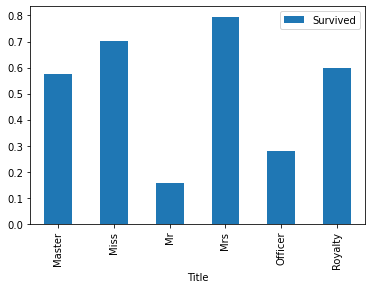

In [82]:
title_pivot = train.pivot_table(index="Title",values="Survived")
title_pivot.plot.bar()
plt.show()

As we expected, women titles show higher survival rates than men. Next come higher up men ranks such as `Master` and `Royalty` before officers or simple men.

### Combining `SibSp` and `Parch`

As shown previously, the `SibSp` and `Parch` columns convey the same type of information. As a consequence, it may be interesting to combine them in a single feature that represents the family size in general. 

In [83]:
train[["SibSp", "Parch"]].dtypes

SibSp    int64
Parch    int64
dtype: object

Both columns are of the same type. We create a function that we name `process_alone` to make the combination. This function creates a new binary column named `Family_size` that contains the value:
* 1 if the passenger had zero family members onboard
* 0 if the passenger had one or more family members onboard

In [84]:
def process_alone(df):
    df['Family_size'] = df[["SibSp","Parch"]].sum(axis=1)
    df['Is_alone'] = 0
    df.loc[(df['Family_size']==0), 'isalone'] = 1
    return df

We apply that function to the `train` and `holdout` dataframes.

In [85]:
train = process_alone(train)
holdout = process_alone(holdout)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Cabin_type,Title,Family_size,Is_alone,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Unknown,Mr,1,0,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,C,Mrs,1,0,NaN
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,0-12,Unknown,Miss,0,0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,50-100,C,Mrs,1,0,NaN
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,0-12,Unknown,Mr,0,0,1.0


We can finally plot the survival rate as a function of the family size.

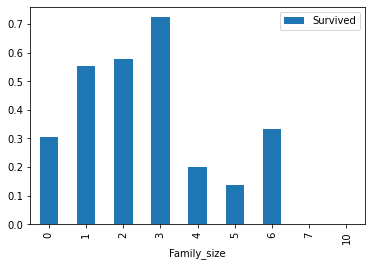

In [86]:
familysize_pivot = train.pivot_table(index="Family_size",values="Survived")
familysize_pivot.plot.bar()
plt.show()

This plot shows the same trend as observed for the `SibSp` and `Parch` columns.

The final step of our feature engineering process is to create dummy columns for our categorical features.

### Creating Dummies

As most machine learning algorithms can't understand text labels, we now have to convert our values into numbers. To do so, we start by creating a generic function named `create_dummies` that:
* creates the dummy columns for the specified column
* adds the dummy columns to the original dataframe

In [87]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Then, we apply this function to all our categorical features.

In [88]:
columns = ["Pclass", "Sex", "Age_categories", "Embarked", "Fare_categories", "Title", "Cabin_type"]

for col in columns:
    train = create_dummies(train,col)
    holdout = create_dummies(holdout,col)

Our features are now usable by a machine learning model. The next step in our workflow is feature selection. We want to select the best-performing features for our model training and our predictions.

## Feature Selection

The next step in our workflow is feature selection. We want to select the most relevant predictors to train our models with. We would also want to avoid having multiple correlated features that could make our models overfit on training data but perform worse on unseen data.

To perform this selection, we will be using the `feature_selection.RFECV` class (scikit-learn's inbuilt) which performs recursive feature elimination with cross-validation.

We write a function that:
* Accepts a dataframe as input
* Performs data preparation for machine learning
* Uses recursive feature elimination and the random forest algorithm to find the best-performing set of features

In [89]:
def select_features(df):
    # Removes any non-numeric columns or columns containing null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    
    all_X = df.drop(["Survived", "PassengerId"], axis=1)    
    all_y = df["Survived"]
    
    rf = RandomForestClassifier(random_state=1)
    
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    return best_columns

We run the newly created function using the `train` dataframe as input.

In [90]:
best_columns = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Fare', 'Family_size', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_S', 'Title_Mr', 'Cabin_type_Unknown']



## Model Selection and Tuning

Now comes the time to find the best model. Several options are left to us as to the type of model that would best perform and the set of optimal parameters it would need.

Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train them using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries where each element of the list is a dictionary. Each dictionary should contain:
* The name of the particular model
* An estimator object for the model
* A dictionary of hyperparameters that we'll use for grid search.

We decide to train and evaluate three algorithms: a logistic regression, a K-nearest neighbors and a random forest. 

We can then use a for loop to iterate over the list of dictionaries, and for each one use scikit-learn's `model_selection.GridSearchCV` class to find the best set of parameters. We then add values for both the parameter set and the score to the dictionary.

Finally, we return the list of dictionaries, which will have our trained `GridSearchCV` objects as well as the results so we can see which one was the most accurate.

In [119]:
def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]
    models = [{"name":"Logistic Regression",
               "estimator":LogisticRegression(),
               "hyperparameters":{
                    "solver":["newton_cg","lbfgs","liblinear"]
                }
               },
               {"name":"KNeighbors Classifier",
                "estimator":KNeighborsClassifier(),
                "hyperparameters":{
                    "n_neighbors":range(1,20,2),
                    "weights":["distance", "uniform"],
                    "algorithm":["ball_tree","kd_tree","brute"],
                    "p":[1,2]
                }
               },
            {"name": "RandomForest Classifier",
             "estimator": RandomForestClassifier(random_state=1),
             "hyperparameters":{
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
             }
        }]
        
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"],cv=10)
        grid.fit(all_X,all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
        
    return models

We finally run this function on the train set, using the previously selected best predictors.

In [120]:
models = select_model(train, best_columns)

Logistic Regression
-------------------
Best Score: 0.8103245942571785
Best Parameters: {'solver': 'lbfgs'}

KNeighbors Classifier
---------------------
Best Score: 0.7857428214731585
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

RandomForest Classifier
-----------------------
Best Score: 0.8361548064918851
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}



The best accuracy score is obtained with the Random Forest model with the set of hyperparameters shown above.

We decide to go ahead with this tuned model and make predictions with it on the holdout set.

## Predictions on the Holdout Set

We end up the workflow by making predictions on the holdout set using the best performing algorithm and set of hyperparameters.

At this stage we may want to go back and forth several times between the feature engineering step and the prediction step to try and improve our score.

To make it easier to iterate and export prediction results to Kaggle, we create a function to automate it.

In [128]:
def save_submission_file(model, features, filename='submission.csv'):
    holdout_data = holdout[features]
    holdout_predictions = model.predict(holdout_data)
    holdout_ids = holdout['PassengerId']
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)

We can finally use that function to make predictions on the holdout set using the best model and the best features.

In [129]:
# Selection of the best RandomForest Classifier
best_rf = models[2]["best_estimator"]    

save_submission_file(best_rf, best_columns)

## Submission to Kaggle

After submitting our predictions on the holdout set to Kaggle, we get an accuracy score of 0.75598. This means we managed to predict the survival correctly for about 75% of the passengers in the holdout set. This score is lower than the one we got when predicting on the train data. Our model is likely overfitting to the train data and we may want to go back to the feature engineering step to work on the predictors. 

With such a score, we rank 14984th on the Titanic competition leaderboard.

## Conclusion and Next Steps

In this guided project, we went through the 5 steps of the Kaggle competition workflow:
* Data Exploration 
* Feature Engineering
* Feature Selection
* Model Selection and Tuning
* Prediction and Submission of Results

We created dedicated functions to ease the feature engineering process and build a pipeline for the entire workflow.

After evaluating several model options, we ended up going for a Random Forest Classifier that gave us an accuracy score of 0.83 on the train data and 0.76 on the holdout set. Such a score ranked us 14984th on the Kaggle Titanic competition leaderboard.

Although this is a good start, this score can really be improved. Some potential next steps are:
* Continue to explore the data and create new features, following the workflow and using the functions we created.
* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use different algorithms in the `select_model()` function, like `support vector machines`, `stochastic gradient descent` or `perceptron` linear models.
* Experiment with `RandomizedSearchCV` instead of `GridSearchCV` to speed up our `select_features()` function.